In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import warnings
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")
from skimage import io, color, transform, feature
from my_measures import BinaryClassificationPerformance  
from sklearn.model_selection import train_test_split
%matplotlib inline

### IMPORTANT!!! Make sure you are using BinaryClassificationPerformance v1.03


In [4]:
help(BinaryClassificationPerformance)

Help on class BinaryClassificationPerformance in module my_measures:

class BinaryClassificationPerformance(builtins.object)
 |  BinaryClassificationPerformance(predictions, labels, desc, probabilities=None)
 |  
 |  Performance measures to evaluate the fit of a binary classification model, v1.03
 |  
 |  Methods defined here:
 |  
 |  __init__(self, predictions, labels, desc, probabilities=None)
 |      Initialize attributes: predictions-vector of predicted values for Y, labels-vector of labels for Y
 |  
 |  compute_measures(self)
 |      Compute performance measures defined by Flach p. 57
 |  
 |  img_indices(self)
 |      Get the indices of true and false positives to be able to locate the corresponding images in a list of image names
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the obj

### file paths and names

In [5]:
ci_path = 'plane_data/cropped_images/' # file path for cropped images for training
l_file = 'plane_data/plane_labels.csv' # file path and file name for csv with labels

# Function for feature building and extraction on photographs¶

scikit-image documentation on methods used for feature extraction:  

* http://scikit-image.org/docs/dev/api/skimage.color.html#rgb2gray  
* http://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize  
* http://scikit-image.org/docs/stable/api/skimage.feature.html#skimage.feature.canny

In [6]:
# in downscaling the image, what do you want the new dimensions to be?
# the original dimensions of cropped images: (60, 140), which if 8,400 pixels
dims = (15, 35) # 25% of the original size, 525 pixels

In [59]:
def image_manipulation(imname, imgs_path, imview=False):
    warnings.filterwarnings('ignore')
    imname = imgs_path + imname + '.png'
    img_raw = io.imread(imname, as_gray=True)
    downscaled = transform.resize(img_raw, (dims[0], dims[1])) # downscale image
    final_image = feature.canny(downscaled, sigma=0.01) # edge filter image with Canny algorithm
    if imview==True:
        io.imshow(final_image)
    warnings.filterwarnings('always')
    return final_image

# test the function, look at input/output
test_image = image_manipulation('2017-08-25T23+24+13_390Z', ci_path, True)
print('downscaled image shape: ')
print(test_image.shape)
print('image representation (first row of pixels): ')
print(test_image[0])
print('\n')
print('example of transformation: ')

/Users/maybaho/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


TypeError: numpy boolean subtract, the `-` operator, is not supported, use the bitwise_xor, the `^` operator, or the logical_xor function instead.

for comparison, look at original image:

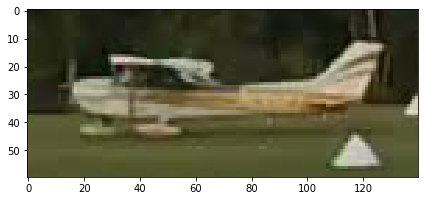

In [60]:
this_imname = ci_path + '2017-08-25T23+24+13_390Z.png'
io.imshow(io.imread(this_imname))

# function to process raw images, resulting in training and test datasets

In [61]:
# function that takes raw images and completes all preprocessing required before model fits
def process_raw_data(labels_fn, images_fp, my_random_seed, imview=False, test=False):
    plane_data = pd.read_csv(labels_fn) # read in photograph labels
    print("First few lines of image labels: ")
    print(plane_data.head())
    print("Size of image label dataFrame: ")
    print(plane_data.shape)
        
    # construct lists for features, labels, and a crosswalk reference to image names
    features_list = []
    if (not test):
        y_list = []
    imnames_list = []

    for index, row in plane_data.iterrows():
        features_list.append(image_manipulation(row['img_name'], images_fp))
        if (not test):
            y_list.append(row['plane'])
        imnames_list.append(row['img_name'])
    
    # convert the lists to ndarrays
    features = np.asarray(features_list)
    if (not test):
        Y = np.asarray(y_list)
    imgs = np.asarray(imnames_list)
    print('Shape of original feature representation: ')
    print(features.shape)

    # flatten the images ndarray to one row per image
    features_flat = features.reshape((features.shape[0], -1))

    print('Shape of flat feature representation: ')
    print(features_flat.shape)

    if (not test):
        print('Shape of Y: ')
        print(Y.shape)

        print('Number of images with planes: ')
        print(Y.sum())
    
        # create train and test sets
        data_train, data_test, y_train, y_test, imgs_train, imgs_test = train_test_split(features_flat, 
            Y, imgs, test_size = 0.25, random_state = my_random_seed)

        print('Shape of training set: ')
        print(y_train.shape)
        print('Number of training images that contain an airplane: ')
        print(y_train.sum())

        print('Shape of test set: ')
        print(y_test.shape)
        print('Number of test images that contain an airplane: ')
        print(y_test.sum())
    
    if (test):
        X_submission_test = features_flat
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(X_submission_test, plane_data)
    else: 
        print("Shape of data_train and data_test:")
        print(data_train.shape)
        print(data_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of imgs_train and imgs_test:")
        print(imgs_train.shape)
        print(imgs_test.shape)
        print('SUCCESS!')
        return(data_train, data_test, y_train, y_test, imgs_train, imgs_test)


In [62]:
data_train, data_test, y_train, y_test, imgs_train, imgs_test = process_raw_data(l_file, ci_path, 
    my_random_seed=13, imview=False, test=False)

First few lines of image labels: 
                   img_name  plane
0  2016-08-02T13+50+24_430Z  False
1  2016-08-02T14+12+37_390Z  False
2  2016-08-02T22+20+26_600Z  False
3  2016-08-03T12+04+30_670Z  False
4  2016-08-03T12+32+21_790Z  False
Size of image label dataFrame: 
(6758, 2)
Shape of original feature representation: 
(6758, 15, 35)
Shape of flat feature representation: 
(6758, 525)
Shape of Y: 
(6758,)
Number of images with planes: 
101
Shape of training set: 
(5068,)
Number of training images that contain an airplane: 
80
Shape of test set: 
(1690,)
Number of test images that contain an airplane: 
21
Shape of data_train and data_test:
(5068, 525)
(1690, 525)
Shape of y_train and y_test:
(5068,)
(1690,)
Shape of imgs_train and imgs_test:
(5068,)
(1690,)
SUCCESS!


# train Perceptron

In [63]:
# MODEL: Perceptron
from sklearn import linear_model
prc = linear_model.SGDClassifier(loss='perceptron')
prc.fit(data_train, y_train)

prc_performance = BinaryClassificationPerformance(prc.predict(data_train), y_train, 'prc')
prc_performance.compute_measures()
prc_performance.performance_measures['set'] = 'train'
print('TRAINING SET: ')
print(prc_performance.performance_measures)

prc_performance_test = BinaryClassificationPerformance(prc.predict(data_test), y_test, 'prc')
prc_performance_test.compute_measures()
prc_performance_test.performance_measures['set'] = 'test'
print('TEST SET: ')
print(prc_performance_test.performance_measures)

prc_performance_test.img_indices()
prc_img_indices_to_view = prc_performance_test.image_indices

TRAINING SET: 
{'Pos': 80, 'Neg': 4988, 'TP': 58, 'TN': 4988, 'FP': 0, 'FN': 22, 'Accuracy': 0.9956590370955012, 'Precision': 1.0, 'Recall': 0.725, 'desc': 'prc', 'set': 'train'}
TEST SET: 
{'Pos': 21, 'Neg': 1669, 'TP': 11, 'TN': 1656, 'FP': 13, 'FN': 10, 'Accuracy': 0.9863905325443787, 'Precision': 0.4583333333333333, 'Recall': 0.5238095238095238, 'desc': 'prc', 'set': 'test'}


/Users/maybaho/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [64]:
def performance_examples(typ, measures):
    iiv = ''
    if typ == 'FP':
        iiv = typ + '_indices'
    elif typ == 'TP':
        iiv = typ + '_indices'
    elif typ == 'FN':
        iiv = typ + '_indices'
    else:
        raise ValueError('input must be "TP", "FP", or "FN"')
    for img in measures[iiv]:
        warnings.filterwarnings('ignore')    
        plt.figure()
        lookat = ci_path + imgs_test[img] + '.png' # location of original image
        io.imshow(lookat) # show original image
        plt.figure()
        io.imshow(data_test[img].reshape(dims[0], dims[1])) # show manipulation for feature representation
        warnings.filterwarnings('always')


/Users/maybaho/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# look at examples of Perceptron classifications

## true positives

/Users/maybaho/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


TypeError: numpy boolean subtract, the `-` operator, is not supported, use the bitwise_xor, the `^` operator, or the logical_xor function instead.

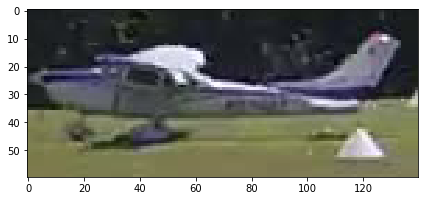

<Figure size 432x288 with 0 Axes>

In [28]:
performance_examples('TP', prc_img_indices_to_view)

## false positives

In [ ]:
performance_examples('FP', prc_img_indices_to_view)

## false negatives

In [ ]:
performance_examples('FN', prc_img_indices_to_view)

# train Multilayer Perceptron, a.k.a. neural network

# look at examples of neural network classifications

In [65]:
# MODEL: Multi-layer Perceptron aka neural network
from sklearn import neural_network
nn = neural_network.MLPClassifier(max_iter=1000)
print(nn)
nn.fit(data_train, y_train)

nn_performance = BinaryClassificationPerformance(nn.predict(data_train), y_train, 'nn')
nn_performance.compute_measures()
nn_performance.performance_measures['set'] = 'train'
print('TRAINING SET: ')
print(nn_performance.performance_measures)

nn_performance_test = BinaryClassificationPerformance(nn.predict(data_test), y_test, 'nn_test')
nn_performance_test.compute_measures()
nn_performance_test.performance_measures['set'] = 'test'
print('TEST SET: ')
print(nn_performance_test.performance_measures)

nn_performance_test.img_indices()
nn_img_indices_to_view = nn_performance_test.image_indices

MLPClassifier(max_iter=1000)


/Users/maybaho/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


TRAINING SET: 
{'Pos': 80, 'Neg': 4988, 'TP': 80, 'TN': 4988, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'nn', 'set': 'train'}
TEST SET: 
{'Pos': 21, 'Neg': 1669, 'TP': 9, 'TN': 1665, 'FP': 4, 'FN': 12, 'Accuracy': 0.9905325443786982, 'Precision': 0.6923076923076923, 'Recall': 0.42857142857142855, 'desc': 'nn_test', 'set': 'test'}


In [66]:
print('HIDDEN LAYERS = 100, 50, 50')

nn1 = neural_network.MLPClassifier(learning_rate_init=.01, hidden_layer_sizes=(100,50,50), max_iter=100000)
nn1.fit(data_train, y_train)

nn1_performance = BinaryClassificationPerformance(nn1.predict(data_train), y_train, 'nn1')
nn1_performance.compute_measures()
nn1_performance.performance_measures['set'] = 'train'
print('TRAINING SET: ')
print(nn1_performance.performance_measures)

nn1_performance_test = BinaryClassificationPerformance(nn1.predict(data_test), y_test, 'nn1_test')
nn1_performance_test.compute_measures()
nn1_performance_test.performance_measures['set'] = 'test'
print('TEST SET: ')
print(nn1_performance_test.performance_measures)

nn1_performance_test.img_indices()
nn1_img_indices_to_view = nn1_performance_test.image_indices


HIDDEN LAYERS = 100, 50, 50


/Users/maybaho/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


TRAINING SET: 
{'Pos': 80, 'Neg': 4988, 'TP': 80, 'TN': 4988, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'nn1', 'set': 'train'}
TEST SET: 
{'Pos': 21, 'Neg': 1669, 'TP': 14, 'TN': 1657, 'FP': 12, 'FN': 7, 'Accuracy': 0.9887573964497042, 'Precision': 0.5384615384615384, 'Recall': 0.6666666666666666, 'desc': 'nn1_test', 'set': 'test'}


In [67]:
print('HIDDEN LAYERS = 100, 50, 20, 13')

nn2 = neural_network.MLPClassifier(learning_rate_init=.01, hidden_layer_sizes=(100,50,20,13), max_iter=100000)
nn2.fit(data_train, y_train)

nn2_performance = BinaryClassificationPerformance(nn2.predict(data_train), y_train, 'nn2')
nn2_performance.compute_measures()
nn2_performance.performance_measures['set'] = 'train'
print('TRAINING SET: ')
print(nn2_performance.performance_measures)

nn2_performance_test = BinaryClassificationPerformance(nn2.predict(data_test), y_test, 'nn2_test')
nn2_performance_test.compute_measures()
nn2_performance_test.performance_measures['set'] = 'test'
print('TEST SET: ')
print(nn2_performance_test.performance_measures)

nn2_performance_test.img_indices()
nn2_img_indices_to_view = nn2_performance_test.image_indices

HIDDEN LAYERS = 100, 50, 20, 13


/Users/maybaho/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


TRAINING SET: 
{'Pos': 80, 'Neg': 4988, 'TP': 80, 'TN': 4988, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'nn2', 'set': 'train'}
TEST SET: 
{'Pos': 21, 'Neg': 1669, 'TP': 12, 'TN': 1658, 'FP': 11, 'FN': 9, 'Accuracy': 0.9881656804733728, 'Precision': 0.5217391304347826, 'Recall': 0.5714285714285714, 'desc': 'nn2_test', 'set': 'test'}


In [68]:
print('HIDDEN LAYERS = 100,50,20,20,10,5')

nn3 = neural_network.MLPClassifier(learning_rate_init=.01, hidden_layer_sizes=(100,50,20,20,10,5), max_iter=100000)
nn3.fit(data_train, y_train)

nn3_performance = BinaryClassificationPerformance(nn3.predict(data_train), y_train, 'nn3')
nn3_performance.compute_measures()
nn3_performance.performance_measures['set'] = 'train'
print('TRAINING SET: ')
print(nn3_performance.performance_measures)

nn3_performance_test = BinaryClassificationPerformance(nn3.predict(data_test), y_test, 'nn3_test')
nn3_performance_test.compute_measures()
nn3_performance_test.performance_measures['set'] = 'test'
print('TEST SET: ')
print(nn3_performance_test.performance_measures)

nn3_performance_test.img_indices()
nn3_img_indices_to_view = nn3_performance_test.image_indices

HIDDEN LAYERS = 100,50,20,20,10,5


/Users/maybaho/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


TRAINING SET: 
{'Pos': 80, 'Neg': 4988, 'TP': 80, 'TN': 4985, 'FP': 3, 'FN': 0, 'Accuracy': 0.9994080505130228, 'Precision': 0.963855421686747, 'Recall': 1.0, 'desc': 'nn3', 'set': 'train'}
TEST SET: 
{'Pos': 21, 'Neg': 1669, 'TP': 10, 'TN': 1660, 'FP': 9, 'FN': 11, 'Accuracy': 0.9881656804733728, 'Precision': 0.5263157894736842, 'Recall': 0.47619047619047616, 'desc': 'nn3_test', 'set': 'test'}


In [69]:
print('HIDDEN LAYERS = 100, 13, 2')

nn4 = neural_network.MLPClassifier(learning_rate_init=.01, hidden_layer_sizes=(100,13,2), max_iter=100000)
nn4.fit(data_train, y_train)

nn4_performance = BinaryClassificationPerformance(nn4.predict(data_train), y_train, 'nn4')
nn4_performance.compute_measures()
nn4_performance.performance_measures['set'] = 'train'
print('TRAINING SET: ')
print(nn4_performance.performance_measures)

nn4_performance_test = BinaryClassificationPerformance(nn4.predict(data_test), y_test, 'nn4_test')
nn4_performance_test.compute_measures()
nn4_performance_test.performance_measures['set'] = 'test'
print('TEST SET: ')
print(nn4_performance_test.performance_measures)

nn4_performance_test.img_indices()
nn4_img_indices_to_view = nn4_performance_test.image_indices

HIDDEN LAYERS = 100, 13, 2


/Users/maybaho/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


TRAINING SET: 
{'Pos': 80, 'Neg': 4988, 'TP': 80, 'TN': 4988, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'nn4', 'set': 'train'}
TEST SET: 
{'Pos': 21, 'Neg': 1669, 'TP': 12, 'TN': 1657, 'FP': 12, 'FN': 9, 'Accuracy': 0.9875739644970414, 'Precision': 0.5, 'Recall': 0.5714285714285714, 'desc': 'nn4_test', 'set': 'test'}


In [70]:
print('HIDDEN LAYERS = 100, 20, 10, 13')

nn5 = neural_network.MLPClassifier(learning_rate_init=.01, hidden_layer_sizes=(100,20,10,13), max_iter=100000)
nn5.fit(data_train, y_train)

nn5_performance = BinaryClassificationPerformance(nn5.predict(data_train), y_train, 'nn5')
nn5_performance.compute_measures()
nn5_performance.performance_measures['set'] = 'train'
print('TRAINING SET: ')
print(nn4_performance.performance_measures)

nn5_performance_test = BinaryClassificationPerformance(nn5.predict(data_test), y_test, 'nn5_test')
nn5_performance_test.compute_measures()
nn5_performance_test.performance_measures['set'] = 'test'
print('TEST SET: ')
print(nn5_performance_test.performance_measures)

nn5_performance_test.img_indices()
nn5_img_indices_to_view = nn5_performance_test.image_indices

HIDDEN LAYERS = 100, 20, 10, 13


/Users/maybaho/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


TRAINING SET: 
{'Pos': 80, 'Neg': 4988, 'TP': 80, 'TN': 4988, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'nn4', 'set': 'train'}
TEST SET: 
{'Pos': 21, 'Neg': 1669, 'TP': 9, 'TN': 1657, 'FP': 12, 'FN': 12, 'Accuracy': 0.9857988165680474, 'Precision': 0.42857142857142855, 'Recall': 0.42857142857142855, 'desc': 'nn5_test', 'set': 'test'}


## true positives

In [ ]:
performance_examples('TP', nn_img_indices_to_view)

## false positives

In [ ]:
performance_examples('FP', nn_img_indices_to_view)

## false negatives

In [ ]:
performance_examples('FN', nn_img_indices_to_view)

# comparisons

In [71]:
# list of fits to compare: 
final_fits = []
final_fits.append(prc_performance.performance_measures)
final_fits.append(prc_performance_test.performance_measures)
final_fits.append(nn_performance.performance_measures)
final_fits.append(nn_performance_test.performance_measures)
final_fits.append(nn1_performance.performance_measures)
final_fits.append(nn1_performance_test.performance_measures)
final_fits.append(nn2_performance.performance_measures)
final_fits.append(nn2_performance_test.performance_measures)
final_fits.append(nn3_performance.performance_measures)
final_fits.append(nn3_performance_test.performance_measures)
final_fits.append(nn4_performance.performance_measures)
final_fits.append(nn4_performance_test.performance_measures)
final_fits.append(nn5_performance.performance_measures)
final_fits.append(nn5_performance_test.performance_measures)

/Users/maybaho/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/Users/maybaho/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


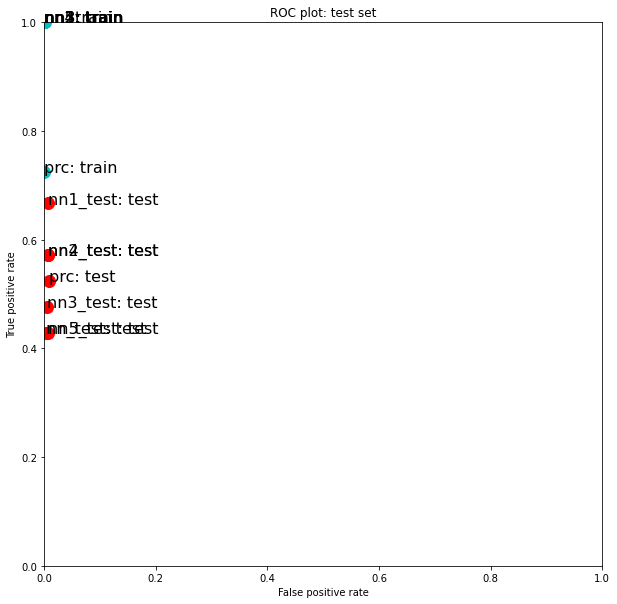

In [72]:
plt.figure(figsize=(10,10))

for fit in final_fits:
    if fit['set'] == 'train':
        color = 'co'
    else:
        color = 'ro'
    plt.plot(fit['FP'] / fit['Neg'], 
             fit['TP'] / fit['Pos'], color, markersize=12)
    plt.text(fit['FP'] / fit['Neg'], 
             fit['TP'] / fit['Pos'], fit['desc'] + ': ' + fit['set'], fontsize=16)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()


# SUBMISSION

### file paths and names:

In [20]:
submission_ci_path = 'test_data_for_grading/test_cropped_images/' # file path for cropped images for training
submission_l_file = 'test_data_for_grading/test_plane_labels.csv' # file path and file name for csv with labels

In [21]:
X_test_data, X_test_submission = process_raw_data(submission_l_file, submission_ci_path, my_random_seed=13, test=True)
print("Number of rows in the submission test set (should be 1,523): ")

First few lines of image labels: 
                   img_name
0  2016-08-02T13+50+24_430Z
1  2016-08-02T14+12+37_390Z
2  2016-08-03T12+32+21_790Z
3  2016-08-03T13+19+28_320Z
4  2016-08-05T15+24+58_670Z
Size of image label dataFrame: 
(1523, 1)
Shape of original feature representation: 
(1523, 15, 35)
Shape of flat feature representation: 
(1523, 525)
Shape of X_test for submission:
(1523, 525)
SUCCESS!
Number of rows in the submission test set (should be 1,523): 


### IMPORTANT CHECK: make sure that the number of columns in your training data is the same as the number of columns in this test submission!

In [22]:
print(data_train.shape)
print(X_test_data.shape)

(5068, 525)
(1523, 525)


Both the training set and submission test set have 525 columns. Success!

---

Choose a *single* model for your submission. In this code, I am choosing the Perceptron model fit, which is in the prc object. But you should choose the model that is performing the best for you!

In [23]:
# concatenate predictions to the id
X_test_submission["prediction"] = prc.predict(X_test_data)
# look at the proportion of positive predictions
print(X_test_submission['prediction'].mean())

0.016414970453053186


This is the proportion of predictions that have predicted that there is an airplane in the image.

In [24]:
print(X_test_submission.shape) # should be (1523, 2)

(1523, 2)


In [25]:
# export submission file as pdf
# CHANGE FILE PATH: 
X_test_submission.to_csv('airplane_submission.csv', index=False)